In [1]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


## Creating the dataset

We need the dataset at least for testing the models

**IMPORTANT**: make sure the model_name parameter is set correctly for the evaluation. Otherwise batch_handler will give you "index out of bounds" errors.



In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=0, quick_run=False, num_of_input_chnls=3,
                         model_name="rd3", type_of_map="e_map")

INFO - Preparing experimental handlers. This may take a while. Be patient...


  0%|          | 0/100 [00:00<?, ?it/s]

INFO - Ready. Loop through patient ids.


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


In [6]:
roi_stats = dataset.roi_stats["train"]
print(roi_stats)
print("Perc of positives {:.5f}".format(float(roi_stats[1])/roi_stats[0]))

[1359330    1130     409     721]
Perc of positives 0.00083


In [87]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=False, cuda=True, keep_bounding_boxes=False, verbose=False)


In [ ]:
idx = None
for s in np.arange(len(dataset.test_labels)):
    img = dataset.test_labels[s]
    if 0 != np.count_nonzero(img):
        idx = s
    
        if idx > 25:
            break
    
idx = 133
test_img = dataset.test_images[idx]
test_lbl = dataset.test_labels[idx]
test_pred_roi = dataset.test_pred_lbl_rois[idx]
print(test_img.shape, test_lbl.shape)
print(test_pred_roi)

fig = plt.figure(figsize=(56, 50))
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(test_img[0], cmap=cm.gray)
ax1.imshow(test_img[2], cmap=mycmap)
# ax1.imshow(test_lbl, cmap=mycmap)
# ax1.imshow(test_img[1], cmap=mycmap)
roi_box = BoundingBox.create(test_pred_roi, padding=0)
print(roi_box.width, roi_box.height)
ax1.add_patch(roi_box.get_matplotlib_patch(color='b'))

plt.axis("off")
plt.show()
# ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
# ax2.imshow(test_lbl, cmap=cm.gray)
# plt.axis("off")

[ 150.   74.  222.  146.]


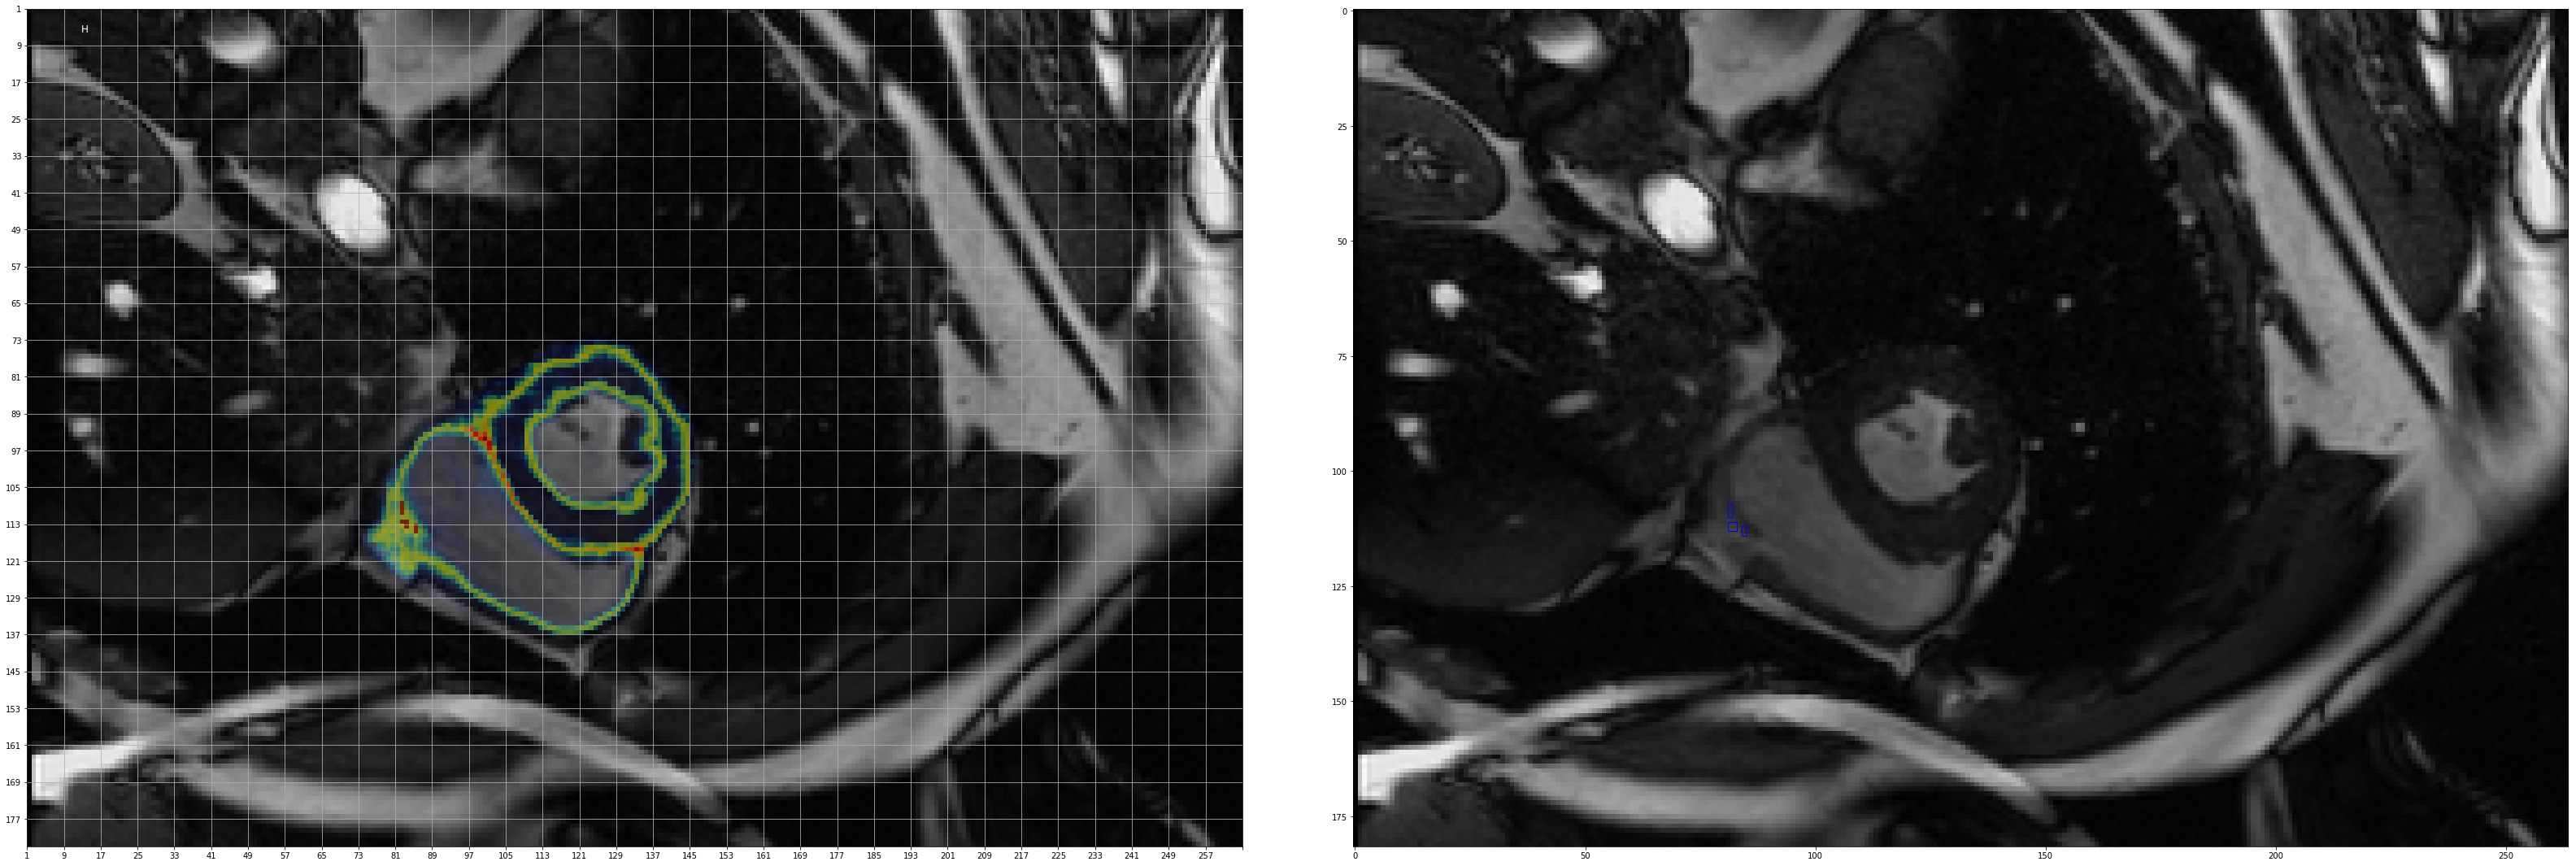

In [68]:
slice_num = 197
batch_nr = 1
image = dataset.train_images[slice_num]
label = dataset.train_labels[slice_num]
bbox = new_batch.batch_bounding_boxes[batch_nr]
bbox = BoundingBox.create(bbox)
print(bbox.box_four)
fig = plt.figure(figsize=(56, 50))

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
w, h = image[0].shape
ax1.imshow(image[0], cmap=cm.gray)
ax1.imshow(image[1], cmap=mycmap)
ax1.imshow(label, cmap=mycmap)

ax1.grid(which='minor', color='w', linestyle='-', linewidth=4)
ax1.set_xticks(np.arange(-.5, h, 8))
ax1.set_yticks(np.arange(-.5, w, 8))
ax1.set_xticklabels(np.arange(1, h+1, 8))
ax1.set_yticklabels(np.arange(1, w+1, 8))
ax1.text(12, 4, 'H', size='large',
            ha='center', va='center', color='w')
plt.grid(True)
# ax1.add_patch(bbox.get_matplotlib_patch(color='b'))
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(image[0], cmap=cm.gray)

for roi_idx in np.arange(dataset.train_lbl_rois[slice_num].shape[0]):
    box_four = dataset.train_lbl_rois[slice_num][roi_idx]
    roi_box = BoundingBox.create(box_four)
    ax2.add_patch(roi_box.get_matplotlib_patch(color='b'))

# ax1.imshow(center_mask, cmap=mycmap)
plt.show()

In [9]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=True, cuda=True, keep_bounding_boxes=True, verbose=False,
                         num_of_max_pool_layers=4)
batch_imgs, _target_labels_per_roi = new_batch(batch_size=batch_size)
print(new_batch.dataset_slice_ids)

[2733, 593, 453, 2758, 5144, 2864, 2340, 3337]


In [20]:
target_labels = new_batch.target_labels_per_roi
# this is a dict with keys 1, 4, 8
print(np.where(target_labels[8][0] !=0 ))

(array([20, 21, 29, 30, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 65,
       66, 67, 68]),)


number_of_slices 39 height, width 312, 16


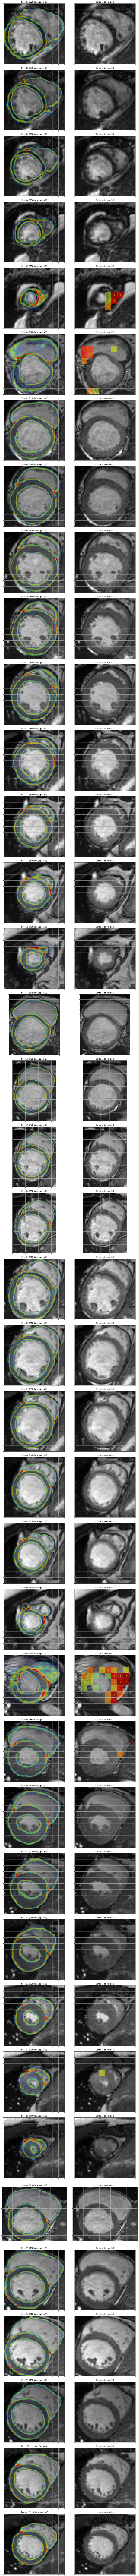

In [42]:
eval_batch_rd1.visualize_batch(grid_spacing=8, index_range=[61, 100], base_apex_only=False, sr_threshold=0.45)

In [10]:
from utils.detector.exper_handler import create_experiment

# FIRST ROUND OF EXPERIMENTS
# exper_id_rd2 = "20181016_11_49_37_rd2_f0p01_brier_emap_200KE_lr1e04"
# exper_id_rd1 = "20181016_11_46_00_rd1_f0p01_brier_emap_200KE_lr1e04"
# exper_id_rd2_bayes = "20181016_18_17_47_rd1_f0p01_brier_umap_200KE_lr1e04"
# exper_id_rd3 = "20181023_12_10_48_rd3_f0_emap_brier_emap_50KE_lr1e05"

# exper_id_rd1_a = "20181024_14_19_56_rd1_f0_brier_emap_15KE_lr1e04" # take 10k model (neg_frac=0.2!)
# exper_id_rd1_b = "20181024_14_08_59_rd1_f0_brier_emap_15KE_lr1e04" # take 10k model (neg_frac=0.67)

# exper_id_rd2 = "20181024_15_39_57_rd2_f0_brier_emap_12KE_lr1e04"  # take 12k model (neg_frac=0.67, fn=0.3, fp=0)

# exper_id_rd3_a = "20181024_16_42_51_rd3_f0_brier_emap_12KE_lr1e04" # (neg_frac=0.67, fn=0.3, fp=0)
# exper_id_rd3_b = "20181024_18_09_02_rd3_f0_brier_emap_12KE_lr1e04" # (neg_frac=0.67, fn=0.3, fp=0)

# 02-11-2018 made rd1 and rd3 smaller w.r.t. #feature_maps. So not compatible with experiments above
exper_id_rd1_a = "20181102_11_05_32_rd1_f0_brier_emap_20KE_lr1e04"  # best@15K fp=0.5 fn=0.1

exper_id_rd3_a = "20181102_11_05_07_rd3_f0_brier_emap_20KE_lr1e04"  # best@20K fp=0.3 fn=0.1

exp_handler_rd1 = create_experiment(exper_id_rd1_a)
exp_handler_rd3 = create_experiment(exper_id_rd3_a)


Load experiment from /home/jorg/repository/dcnn_acdc/logs/RD/20181102_11_05_32_rd1_f0_brier_emap_20KE_lr1e04/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/RD/20181102_11_05_07_rd3_f0_brier_emap_20KE_lr1e04/stats/exper_stats.dll


In [16]:
exper_handler = exp_handler_rd1

rd_model = exper_handler.load_checkpoint(checkpoint=15000)

Creating new model RegionDetector: rd1-detector
INFO - RegionDetector - debug - num_of_channels_last_layer 32


## Testing the model

**IMPORTANT**

(1) make sure that for model RD3!!! the dataset object was created with model=rd3, otherwise you'll get an error in the batch_handler.py with something like "...index out of bounds..."

(2) make sure is_test is set to True in eval method of experiment handler

In [60]:

exp_handler.exper.config.get_architecture(model_name=exp_handler.exper.run_args.model)
eval_batch_rd1 = exp_handler.eval(dataset, rd_model, eval_size=500, keep_batch=True, verbose=False, is_test=True,
                              disrupt_chnnl=None)
eval_batch_rd1.fill_trans_dict()

---> END VALIDATION epoch 20000 #slices=451(skipped 5) (negatives/positives=47011/849) loss 0.084: f1=0.504 - roc_auc=0.966 - pr_auc=0.547 - prec=0.424 - rec=0.622 - 1.05 seconds


In [58]:
batch_extra_labels = np.array(eval_batch_rd1.batch_extra_labels)
print(batch_extra_labels.shape[0], np.count_nonzero(batch_extra_labels))

456 100


## Generate FROC curves (detection rate)

### Import or Generate

In [52]:
from utils.froc import compute_froc, load_froc_data

num_of_slices, num_of_grids

threshold_sensitivity_rd1, threshold_precision_rd1, threshold_fp_rd1, slice_sensitivity_rd1, \
            slice_threshold_precision_rd1, slice_fp_rd1, \
            threshold_list_rd1, num_of_slices, num_of_grids = load_froc_data(exp_handler)

INFO - Loaded froc data successfully fro, /home/jorg/repository/dcnn_acdc/logs/RD/20181102_11_05_32_rd1_f0_brier_emap_20KE_lr1e04/stats/froc_data.npz


In [91]:
from utils.froc import compute_froc, load_froc_data

pred_probs = eval_batch_rd1.flatten_batch_probs()
gt_labels = np.array(eval_batch_rd1.batch_gt_labels)
base_apex_labels = np.array(eval_batch_rd1.batch_extra_labels)
num_of_slices = len(eval_batch_rd1.batch_slice_gt_labels)

threshold_sensitivity_rd1, threshold_precision_rd1, threshold_fp_rd1, slice_sensitivity_rd1,  \
                slice_threshold_precision_rd1, slice_fp_rd1, \
                threshold_list_rd1, num_of_slices, num_of_grids = \
                compute_froc(pred_probs, gt_labels, nbr_of_thresholds=50, range_threshold=None,
                             slice_probs_dict=eval_batch_rd1.batch_slice_pred_probs ,
                             slice_labels_dict=eval_batch_rd1.batch_slice_gt_labels, exper_handler=exp_handler_rd1,
                             base_apex_labels=None, loc=0)  # base_apex_labels
    
gt_slice_labels = np.hstack(eval_batch_rd1.batch_slice_gt_labels.values())
batch_labels_apex_base = np.array(eval_batch_rd1.batch_extra_labels)

slices_containing_regions = np.count_nonzero(gt_slice_labels)
base_apex_containing_regions = np.count_nonzero(np.logical_and(gt_slice_labels, batch_labels_apex_base))

print("Slices containint regions {}. Base/apex of these {}".format(slices_containing_regions, 
                                                                   base_apex_containing_regions))
    
print("Ready")

INFO - Saved froc data successfully to /home/jorg/repository/dcnn_acdc/logs/RD/20181102_11_05_32_rd1_f0_brier_emap_20KE_lr1e04/stats/froc_data
Slices containint regions 152. Base/apex of these 50
Ready


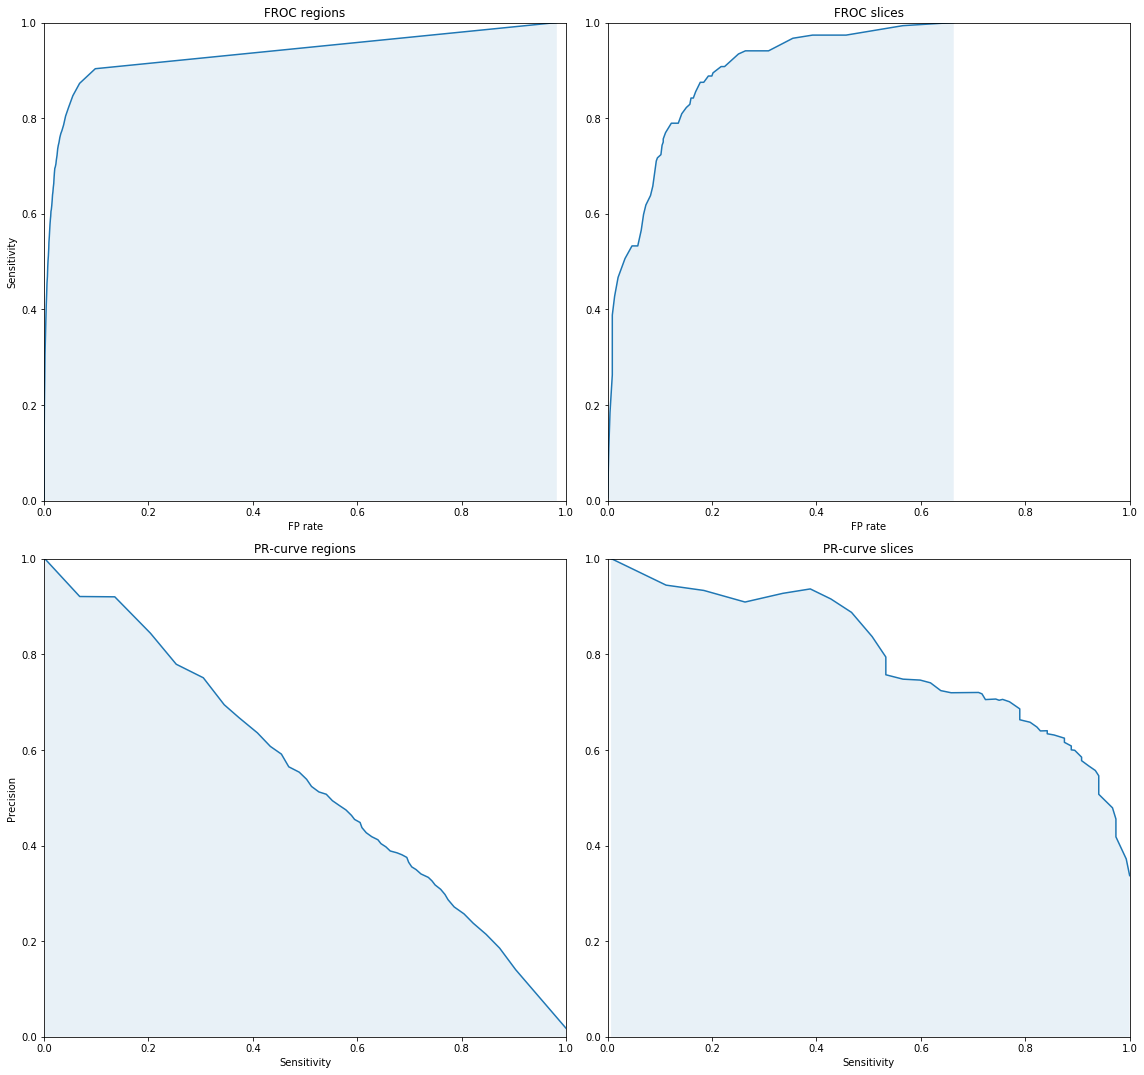

In [95]:

width = 16
height =16
fig = plt.figure(figsize=(width, height))
x_values = np.linspace(0, 1., 50)

ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax1.plot(threshold_fp_rd1[::-1] * 1./num_of_grids, threshold_sensitivity_rd1[::-1])
ax1.fill_between(threshold_fp_rd1[::-1] * 1./num_of_grids, threshold_sensitivity_rd1[::-1], alpha=0.1)
ax1.set_xlim([0., 1.])
ax1.set_ylim([0., 1.])
ax1.set_xlabel("FP rate")
ax1.set_ylabel("Sensitivity")
ax1.set_title("FROC regions")
# ax1.plot(threshold_fp_rd3[::-1], threshold_sensitivity_rd3[::-1], c='r')
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
perc_fp_rd1 = slice_fp_rd1 * 1./num_of_slices
ax2.plot(perc_fp_rd1[::-1], slice_sensitivity_rd1[::-1])
ax2.fill_between(perc_fp_rd1[::-1], slice_sensitivity_rd1[::-1], alpha=0.1)
ax2.set_xlim([0., 1.])
ax2.set_ylim([0., 1.])
ax2.set_xlabel("FP rate")
ax2.set_title("FROC slices")
# precision/recall regions
ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax3.plot(threshold_sensitivity_rd1[::-1], threshold_precision_rd1[::-1])
ax3.fill_between(threshold_sensitivity_rd1[::-1], threshold_precision_rd1[::-1], alpha=0.1)
ax3.set_xlabel("Sensitivity")
ax3.set_ylabel("Precision")
ax3.set_xlim([0., 1.])
ax3.set_ylim([0., 1.])
ax3.set_title("PR-curve regions")
# precision/recall slices
ax4 = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4.plot(slice_sensitivity_rd1[::-1], slice_threshold_precision_rd1[::-1])
ax4.fill_between(slice_sensitivity_rd1[::-1], slice_threshold_precision_rd1[::-1], alpha=0.1)
ax4.set_xlabel("Sensitivity")
ax4.set_xlim([0., 1.])
ax4.set_ylim([0., 1.])
ax4.set_title("PR-curve slices")
# ax2.plot(slice_fp_rd3[::-1] * 1./num_of_slices, slice_sensitivity_rd3[::-1], c='r')

idx = np.where((perc_fp_rd1 >= 0.13) & (perc_fp_rd1 <= 0.14))
# print(idx)
# print(threshold_list_rd1[idx])
# print(slice_sensitivity_rd1[idx])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [13]:
patient_id = eval_batch.trans_dict[428]
print(patient_id)
print(dataset.trans_dict[patient_id])

patient097
(False, [424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439])


In [8]:
def compute_tp_tn_fn_fp(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    tp_idx = result & reference
    fn = np.count_nonzero(~result & reference)
    fn_idx = ~result & reference
    tn = np.count_nonzero(~result & ~reference)
    tn_idx = ~result & ~reference
    fp = np.count_nonzero(result & ~reference)
    fp_idx = result & ~reference
    print(np.count_nonzero(fp_idx))
    return tuple((tp, tp_idx)), tuple((fn, fn_idx)), tuple((tn, tn_idx)), tuple((fp, fp_idx))


In [31]:
from utils.dslices.accuracies import compute_eval_metrics

grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

labels_stats_filtered_idx = np.logical_or(label_stats > 20., label_stats == 0)

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

label_stats_filtered = label_stats[labels_stats_filtered_idx]
pred_labels_filtered = pred_labels[labels_stats_filtered_idx]
pred_probs_filtered = pred_probs[labels_stats_filtered_idx]
gt_labels_filtered = gt_labels[labels_stats_filtered_idx]

print(label_stats.shape, np.sum(label_stats), np.sum(label_stats_filtered), 
      np.count_nonzero(label_stats_filtered))

f1, roc_auc, pr_auc, prec, rec, fpr, tpr, precision, recall = \
            compute_eval_metrics(gt_labels_filtered, pred_labels_filtered, pred_probs_filtered)

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels_filtered, gt_labels_filtered)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("roc_auc {:.3f} pr_auc {:.3f} Precision {:.3f} / Recall {:.3f}".format(roc_auc, pr_auc, 
                                                                             float(tp)/(tp+fp), 
                                                                             float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

(40727,) 13738.0 9473.0 232
1645
roc_auc 0.957 pr_auc 0.541 Precision 0.100 / Recall 0.789


Total #grids=40727; #negatives=39905; #positives=822
1645
Precision 0.253 / Recall 0.678
Number of fp=1645 fn=265
Voxels all=13738.0, tp=0.75, fn=0.25
(64,) (63,) (63,) (63,)


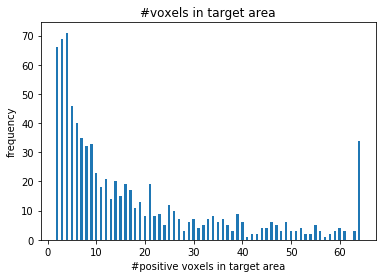

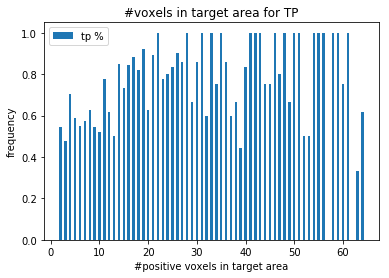

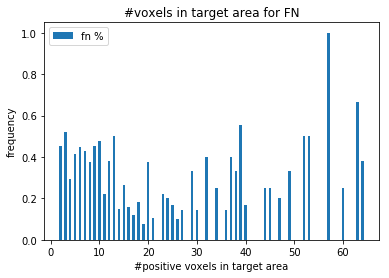

In [28]:
grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

total_num_grids = gt_labels.shape[0]
total_positives = np.count_nonzero(label_stats != 0)
total_negatives = total_num_grids - total_positives

print("Total #grids={}; #negatives={}; #positives={}".format(total_num_grids, total_negatives, total_positives))

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels, gt_labels)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("Precision {:.3f} / Recall {:.3f}".format(float(tp)/(tp+fp), float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

label_stats_tp = label_stats[tp_idx]
label_stats_fn = label_stats[fn_idx]
label_stats_fp = label_stats[fp_idx]
pred_probs_tp = pred_probs[tp_idx]
print("Number of fp={} fn={}".format(fp, fn))
num_all_voxels = np.sum(label_stats)
print("Voxels all={}, tp={:.2f}, fn={:.2f}".format(num_all_voxels, np.sum(label_stats_tp)/num_all_voxels, 
                                           np.sum(label_stats_fn)/num_all_voxels))

label_hist, bin_edges = np.histogram(label_stats, bins=np.unique(label_stats))
label_hist_fn, _ = np.histogram(label_stats_fn, bins=np.unique(label_stats))
label_hist_tp, _ = np.histogram(label_stats_tp, bins=np.unique(label_stats))

print(bin_edges.shape, label_hist.shape, label_hist_fn.shape, label_hist_tp.shape)
plt.bar(bin_edges[2:], label_hist[1:], 0.5, align='center')
plt.title("#voxels in target area")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

tp_percs = label_hist_tp / label_hist.astype(np.float)
fn_percs = label_hist_fn / label_hist.astype(np.float)

# Note: bin_edges = [  0.   1.   2.   3 ...] Hence, we omit the first 2 entries because we're not interested
#                                            in the "negatives" i.e. the areas that don't contain positive voxels

plt.bar(bin_edges[2:], tp_percs[1:], width=0.5, align='center', label="tp %")
plt.legend(loc="best")
plt.title("#voxels in target area for TP")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

plt.bar(bin_edges[2:], fn_percs[1:], width=0.5, align='center', label="fn %")
plt.legend(loc="best")
plt.title("#voxels in target area for FN")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

# make plot with x-axis #voxels (as-is) and y-axis mean-softmax per bin



In [3]:
fold_id = 0
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
exper_handler.generate_target_rois_for_learning(mc_dropout=False)

100%|██████████| 25/25 [00:01<00:00, 14.02it/s]
